<img src="acezero_logo.png" alt="ACE Zero Logo" style="width: 100px; float: left"/>
<br>
<br>
<hr style="border-width: 2px"/>

# Missile Example Study

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from collections import defaultdict
from pathlib import Path
from typing import Any
from typing import Dict
from tqdm.notebook import trange, tqdm

### Setup Paths

In [2]:
    # Replace these with your own paths...
data_path = Path(os.getcwd()) / Path("data/scenario005")
scenario_path = data_path / Path("scenario005.json")
results_path = os.getcwd()

### Setup ACE ZEro

In [3]:
import ace_zero_core
from ace_zero_core import acezero
from ace_zero_core.agents.bt_agent.btpilot import BTPilot, BehaviorType
from ace_zero_core.agents.bt_agent.behaviors.tacparams import TacticalParameters
from ace_zero_core.agents.bt_agent.posture import TacticalPosture
from ace_zero_core.utils import nautical_miles_to_metres as nmi_to_m
from ace_zero_core.utils import feet_to_metres as ft_to_m

### Missile Launch Range and Evasion Study

In [4]:
def set_initial_conditions(
    az: acezero.ACEZero,
    run: int,
    blue_behavior: BehaviorType,
    blue_tactics: TacticalParameters, 
    red_behavior: BehaviorType,
    red_tactics: TacticalParameters,
    y_offset: float
) -> None:
    """
    ...
    """
    f1, f2 = az.get_entities()
    
    viper_y = 0.0 + np.random.uniform(-y_offset, +y_offset)
    cobra_y = 0.0 + np.random.uniform(-y_offset, +y_offset)
    
    f1.set_position(x=-30000.0, y=viper_y, z=5000.0)
    f1.set_orientation(psi=0.0, theta=0.0, phi=0.0)
    f1.set_speed(v=300.0)
    f1.set_desired_speed(v_c=300.0)
    f1.sensor.fov = 120.0
    f1.sensor.max_range = 2 * 50000.0
    f1.reset_mission()

    f2.set_position(x=20000.0, y=cobra_y, z=5000.0)
    f2.set_orientation(psi=180.0, theta=0.0, phi=0.0)
    f2.set_speed(v=300.0)
    f2.set_desired_speed(v_c=300.0)
    f2.sensor.fov = 120.0
    f2.sensor.max_range = 2 * 50000.0
    f2.reset_mission()
    
    f1.pilot = ace_zero_core.agents.bt_agent.btpilot.BTPilot(blue_behavior)
    f1.pilot.set_tactics(blue_tactics)
    
    f2.pilot = ace_zero_core.agents.bt_agent.btpilot.BTPilot(red_behavior)
    f2.pilot.set_tactics(red_tactics)

In [5]:
summary_features = [
    "run_number",
    "total_run_time",
    "viper_initial_contact_range",
    "viper_initial_contact_ata",
    "viper_initial_contact_aa",
    "viper_briefed_behavior",
    "viper_briefed_launch_range",
    "viper_briefed_evasion_range",
    "viper_alive",
    "cobra_initial_contact_range",
    "cobra_initial_contact_ata",
    "cobra_initial_contact_aa",
    "cobra_briefed_behavior",
    "cobra_briefed_launch_range",
    "cobra_briefed_evasion_range",
    "cobra_alive",
    "outcome",
    "viper_launched",
    "viper_launch_range",
    "viper_time_at_launch",
    "cobra_launched",
    "cobra_launch_range",
    "cobra_time_at_launch",
]

for posture in TacticalPosture:
    summary_features.append(f"viper_time_in_{posture.name}")
    summary_features.append(f"cobra_time_in_{posture.name}")


In [6]:
def add_run_summary(
    run_number: int, 
    smd: Dict[str,Any], 
    results_df: pd.DataFrame,
    weapons_df: pd.DataFrame,
    tracks_df: pd.DataFrame,
    blue_behavior: BehaviorType,
    blue_tactics: TacticalParameters,
    red_behavior: BehaviorType,
    red_tactics: TacticalParameters,
    blue_posture_count: dict[TacticalPosture, float],
    red_posture_count: dict[TacticalPosture, float]
) -> None:
    """
    Create run summary.
    """
    smd["run_number"].append(run_number)
    
        # Start with extracting out new dataframes for viper and cobra
    viper_df = results_df[results_df.callsign == 'viper'].set_index('timestep')
    cobra_df = results_df[results_df.callsign == 'cobra'].set_index('timestep')

        # Get total run time
    results_last_row = results_df.iloc[-1]
    total_run_time = results_last_row['timestep']
    smd['total_run_time'].append(total_run_time)

        # Extract dataframes at time 0
    viper_df0 = viper_df.iloc[0]
    cobra_df0 = cobra_df.iloc[0]
    
        # Extract dataframes for last timestep
    viper_df_final = viper_df.iloc[-1]
    cobra_df_final = cobra_df.iloc[-1]
    
        # Inital ranges and orientation
    smd["viper_initial_contact_range"].append(viper_df0.contact_range)
    smd["viper_initial_contact_ata"].append(viper_df0.contact_ata)
    smd["viper_initial_contact_aa"].append(viper_df0.contact_aa)
    
    smd["cobra_initial_contact_range"].append(cobra_df0.contact_range)
    smd["cobra_initial_contact_ata"].append(cobra_df0.contact_ata)
    smd["cobra_initial_contact_aa"].append(cobra_df0.contact_aa)
    
        # Behaviors and Tactical Parameters
    smd["viper_briefed_behavior"].append(blue_behavior)
    smd["viper_briefed_launch_range"].append(blue_tactics.launch_range)
    smd["viper_briefed_evasion_range"].append(blue_tactics.evasion_range)
    smd["viper_alive"].append(viper_df_final["alive"])
    
    smd["cobra_briefed_behavior"].append(red_behavior)
    smd["cobra_briefed_launch_range"].append(red_tactics.launch_range)
    smd["cobra_briefed_evasion_range"].append(red_tactics.evasion_range)
    smd["cobra_alive"].append(cobra_df_final["alive"])
    
        #
    outcome: str = "NONE"
    viper_alive = viper_df_final["alive"]
    cobra_alive = cobra_df_final["alive"]
    
    if viper_alive and cobra_alive:
        outcome = "BOTH_SURVIVED"
    if viper_alive and not cobra_alive:
        outcome = "VIPER_WIN"
    if not viper_alive and cobra_alive:
        outcome = "COBRA_WIN"
    if not viper_alive and not cobra_alive:
        outcome = "MUTUAL_KILL"
        
    smd["outcome"].append(outcome)
    
        # Setup weapon dataframes for viper and cobra
    wpn_viper0_filter = (weapons_df.launcher_callsign == 'viper') #& (weapons_df.weapon_id == 0)
    wpn_viper0 = weapons_df[wpn_viper0_filter]#.set_index('timestep')
    
    wpn_cobra0_filter = (weapons_df.launcher_callsign == 'cobra') #& (weapons_df.weapon_id == 0)
    wpn_cobra0 = weapons_df[wpn_cobra0_filter]#.set_index('timestep')
    
        # Now check to see if either of the aircraft have launched.
    viper_launches = wpn_viper0[wpn_viper0.wpn_status == "LAUNCH"]
    cobra_launches = wpn_cobra0[wpn_cobra0.wpn_status == "LAUNCH"]
    
    viper_launched = False
    viper_launch_range = -1.0
    viper_time_at_launch = -1.0
    
    if len(viper_launches):
        viper_launched = True
        viper_launch_range = viper_launches.target_range.iloc[0]
        viper_time_at_launch = viper_launches.timestep.iloc[0]
        
    smd["viper_launched"].append(viper_launched)
    smd["viper_launch_range"].append(viper_launch_range)
    smd["viper_time_at_launch"].append(viper_time_at_launch)
        
    cobra_launched = False
    cobra_launch_range = -1.0
    cobra_time_at_launch = -1.0

    if len(cobra_launches):
        cobra_launched = True
        cobra_launch_range = cobra_launches.target_range.iloc[0]
        cobra_time_at_launch = cobra_launches.timestep.iloc[0]
            
    smd["cobra_launched"].append(cobra_launched)
    smd["cobra_launch_range"].append(cobra_launch_range)
    smd["cobra_time_at_launch"].append(cobra_time_at_launch)

    # Tactical Posture
    for posture, count in blue_posture_count.items():
        smd[f"viper_time_in_{posture.name}"].append(count)

    for posture, count in red_posture_count.items():
        smd[f"cobra_time_in_{posture.name}"].append(count)

In [7]:
def run_msl_evasion_study(
    study_name: str,
    random_seed: int,
    max_runs: int,
    min_lr: float,
    max_lr: float,
    min_er: float,
    max_er: float,
    y_offset: float
    ) -> pd.DataFrame:
    """... """
    np.random.default_rng(random_seed)
    
    results_path = Path(os.getcwd() / Path(study_name))
    summary_dict = {feature : [] for feature in summary_features}
    
    for run_number in trange(1, max_runs + 1):
        az = acezero.ACEZero(
            scenario_uri=scenario_path, 
            results_path=results_path, 
            data_path=data_path, 
            run_number=run_number
        )
        
        blue_behavior = BehaviorType.ATTACK
        blue_tactics = TacticalParameters(
            launch_range = np.random.uniform(min_lr, max_lr),
            evasion_range = np.random.uniform(min_er, max_er)
        )
        
        red_behavior = BehaviorType.ATTACK
        red_tactics = TacticalParameters(
            launch_range = np.random.uniform(min_lr, max_lr),
            evasion_range = np.random.uniform(min_er, max_er)
        )

        set_initial_conditions(
            az = az, 
            run = run_number,
            blue_behavior = blue_behavior,
            blue_tactics = blue_tactics,
            red_behavior = red_behavior,
            red_tactics = red_tactics,
            y_offset=y_offset
        )

        total_run_time = az.run_simulation()
        his_file_path, csv_file_path = az.process_results()
        weapons_csv_file_path = az.results.get_weapons_csv_filename()
        tracks_csv_file_path = az.results.get_tracks_csv_filename()
        
        results_df = pd.read_csv(csv_file_path)
        weapons_df = pd.read_csv(weapons_csv_file_path)
        tracks_df = pd.read_csv(tracks_csv_file_path)

        # Get posture counts
        viper, cobra = az.get_entities()
        blue_posture_count: dict[TacticalPosture, float] = viper.pilot.get_beliefs().get_posture_count()
        red_posture_count: dict[TacticalPosture, float] = cobra.pilot.get_beliefs().get_posture_count()

        #print("Run, BlueHEADON = ", run_number, blue_posture_count[TacticalPosture.HEADON])
                    
        add_run_summary(
            run_number = run_number, 
            smd = summary_dict, 
            results_df = results_df,
            weapons_df = weapons_df,
            tracks_df = tracks_df,
            blue_behavior = blue_behavior,
            blue_tactics = blue_tactics,
            red_behavior = red_behavior,
            red_tactics = red_tactics,
            blue_posture_count = blue_posture_count,
            red_posture_count = red_posture_count
        )
        
        #trajectory_plot = acezero.charts.draw_trajectory_plot(results_df, [], 100.0, weapons_df)
        print("Total Run Time = ", run_number, total_run_time)

        
    # Now that we have all the runs, convert the summary dict to a pandas df.
    summary_df = pd.DataFrame(summary_dict)
    summary_path = results_path.joinpath(study_name).with_suffix(".csv")
    summary_df.to_csv(summary_path, index=False)
    
    return summary_df

In [8]:
#df = run_msl_evasion_study(
#   study_name="msl_evasion-001",
#   random_seed=1234,
#   max_runs=1,
#   min_lr = 30_000.0,
#   max_lr = 50_000.0,
#   min_er = 0_000.0,
#   max_er = 50_000.0
#)

In [9]:
df = run_msl_evasion_study(
    study_name="msl_evasion-case-1",
    random_seed=1234,
    max_runs=1000,
    min_lr = 49_000.0,
    max_lr = 50_000.0,
    min_er = 0_000.0,
    max_er = 50_000.0,
    y_offset=1.0
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Total Run Time =  1 58.1
Total Run Time =  2 120.8
Total Run Time =  3 59.9
Total Run Time =  4 57.800000000000004
Total Run Time =  5 58.0
Total Run Time =  6 58.0
Total Run Time =  7 58.0
Total Run Time =  8 57.800000000000004
Total Run Time =  9 121.1
Total Run Time =  10 61.6
Total Run Time =  11 58.300000000000004
Total Run Time =  12 121.39999999999999
Total Run Time =  13 57.800000000000004
Total Run Time =  14 121.6
Total Run Time =  15 57.9
Total Run Time =  16 121.19999999999999
Total Run Time =  17 57.9
Total Run Time =  18 121.6
Total Run Time =  19 121.39999999999999
Total Run Time =  20 57.800000000000004
Total Run Time =  21 120.69999999999999
Total Run Time =  22 58.300000000000004
Total Run Time =  23 58.800000000000004
Total Run Time =  24 121.8
Total Run Time =  25 58.800000000000004
Total Run Time =  26 300.1
Total Run Time =  27 300.1
Total Run Time =  28 121.1
Total Run Time =  29 121.0
Total Run Time =  30 121.89999999999999
Total Run Time =  31 120.6999999999999

In [10]:
df

,run_number,total_run_time,viper_initial_contact_range,viper_initial_contact_ata,viper_initial_contact_aa,viper_briefed_behavior,viper_briefed_launch_range,viper_briefed_evasion_range,viper_alive,cobra_initial_contact_range,...,viper_time_in_UNKNOWN,cobra_time_in_UNKNOWN,viper_time_in_NEUTRAL,cobra_time_in_NEUTRAL,viper_time_in_DEFENSIVE,cobra_time_in_DEFENSIVE,viper_time_in_HEADON,cobra_time_in_HEADON,viper_time_in_OFFENSIVE,cobra_time_in_OFFENSIVE
0,1,58.0,50000.0,0.001,179.999,BehaviorType.ATTACK,49722.591590,19348.381068,1,50000.0,...,0.2,0.2,0.0,0.0,0.0,0.0,57.9,57.8,0.0,0.0
1,2,120.7,50000.0,0.000,180.000,BehaviorType.ATTACK,49799.981986,29676.651785,1,50000.0,...,0.2,0.2,0.0,0.0,0.0,93.2,27.4,27.4,93.2,0.0
2,3,59.8,50000.0,-0.000,-180.000,BehaviorType.ATTACK,49127.543781,6778.721982,1,50000.0,...,0.2,0.2,0.0,0.0,0.0,4.5,55.1,55.1,4.6,0.0
3,4,57.7,50000.0,0.001,179.999,BehaviorType.ATTACK,49031.428209,24996.442932,0,50000.0,...,0.2,0.2,0.0,0.0,0.0,0.0,57.5,57.6,0.0,0.0
4,5,57.9,50000.0,0.000,180.000,BehaviorType.ATTACK,49681.213269,5988.939926,1,50000.0,...,0.2,0.2,0.0,0.0,0.0,0.0,57.8,57.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,59.1,50000.0,-0.001,-179.999,BehaviorType.ATTACK,49176.350594,18575.468299,1,50000.0,...,0.2,0.2,0.0,0.0,0.0,0.0,59.0,58.9,0.0,0.0
996,997,74.4,50000.0,-0.001,-179.999,BehaviorType.ATTACK,49281.643501,6220.846149,1,50000.0,...,0.2,0.2,0.0,0.0,0.0,31.8,42.4,42.4,31.9,0.0
997,998,300.0,50000.0,0.001,179.999,BehaviorType.ATTACK,49867.155933,10955.636746,0,50000.0,...,0.2,0.2,0.0,0.0,0.0,0.0,57.7,57.7,0.0,0.0
998,999,58.3,50000.0,-0.001,-179.999,BehaviorType.ATTACK,49230.037485,16741.381712,1,50000.0,...,0.2,0.2,0.0,0.0,0.0,0.0,58.2,58.1,0.0,0.0


In [11]:
df.outcome

0          VIPER_WIN
1      BOTH_SURVIVED
2          VIPER_WIN
3          COBRA_WIN
4          VIPER_WIN
           ...      
995        VIPER_WIN
996        VIPER_WIN
997      MUTUAL_KILL
998        VIPER_WIN
999        VIPER_WIN
Name: outcome, Length: 1000, dtype: object

In [12]:
df.outcome.value_counts()

BOTH_SURVIVED    503
COBRA_WIN        236
VIPER_WIN        219
MUTUAL_KILL       42
Name: outcome, dtype: int64

C:\Users\mikep\AppData\Local\Temp\ipykernel_44196\848172128.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(xlabels)
C:\Users\mikep\AppData\Local\Temp\ipykernel_44196\848172128.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ylabels)


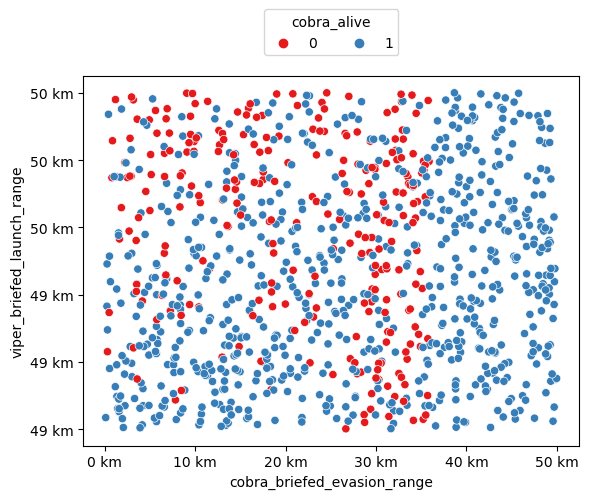

In [13]:
ax = sns.scatterplot(
    data=df,
    x="cobra_briefed_evasion_range",
    y="viper_briefed_launch_range",
    hue="cobra_alive",
    palette="Set1"
)
sns.move_legend(ax, "upper center", ncol=2, bbox_to_anchor=(0.5, 1.2))
xlabels = ['{:,.0f}'.format(x) + ' km' for x in ax.get_xticks()/1000]
_ = ax.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y) + ' km' for y in ax.get_yticks()/1000]
_ = ax.set_yticklabels(ylabels)

C:\Users\mikep\AppData\Local\Temp\ipykernel_44196\973920917.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(xlabels)
C:\Users\mikep\AppData\Local\Temp\ipykernel_44196\973920917.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ylabels)


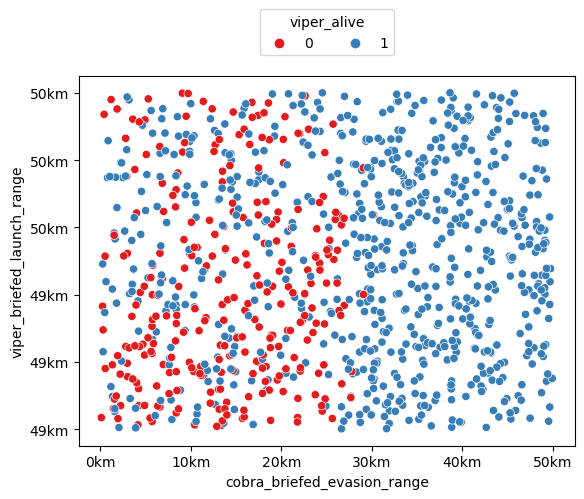

In [14]:
ax = sns.scatterplot(
    data=df,
    x="cobra_briefed_evasion_range",
    y="viper_briefed_launch_range",
    hue="viper_alive",
    palette="Set1"
)
sns.move_legend(ax, "upper center", ncol=2, bbox_to_anchor=(0.5, 1.2))
xlabels = ['{:,.0f}'.format(x) + 'km' for x in ax.get_xticks()/1000]
_ = ax.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y) + 'km' for y in ax.get_yticks()/1000]
_ = ax.set_yticklabels(ylabels)

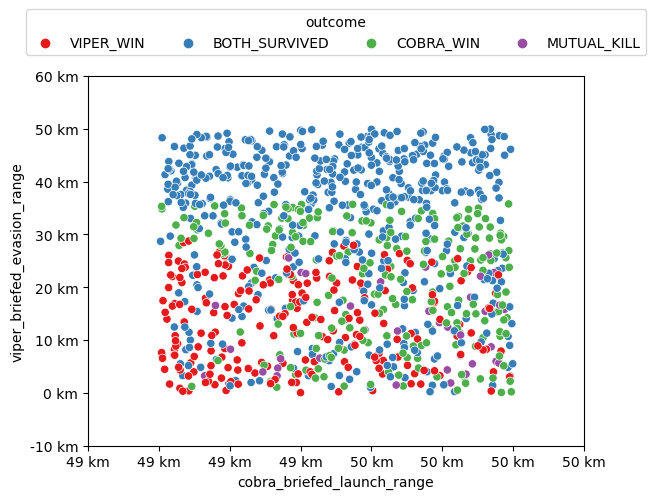

In [15]:
ax = sns.scatterplot(
    data=df,
    x="cobra_briefed_launch_range",
    y="viper_briefed_evasion_range",
    hue="outcome",
    palette="Set1"
)
sns.move_legend(ax, "upper center", ncol=4, bbox_to_anchor=(0.5, 1.2))
xlabels = ['{:,.0f}'.format(x) + ' km' for x in ax.get_xticks()/1000]
ax.set_xticks(ax.get_xticks()) 
_ = ax.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y) + ' km' for y in ax.get_yticks()/1000]
ax.set_yticks(ax.get_yticks()) 
_ = ax.set_yticklabels(ylabels)

In [16]:
df.columns

Index(['run_number', 'total_run_time', 'viper_initial_contact_range',
       'viper_initial_contact_ata', 'viper_initial_contact_aa',
       'viper_briefed_behavior', 'viper_briefed_launch_range',
       'viper_briefed_evasion_range', 'viper_alive',
       'cobra_initial_contact_range', 'cobra_initial_contact_ata',
       'cobra_initial_contact_aa', 'cobra_briefed_behavior',
       'cobra_briefed_launch_range', 'cobra_briefed_evasion_range',
       'cobra_alive', 'outcome', 'viper_launched', 'viper_launch_range',
       'viper_time_at_launch', 'cobra_launched', 'cobra_launch_range',
       'cobra_time_at_launch', 'viper_time_in_UNKNOWN',
       'cobra_time_in_UNKNOWN', 'viper_time_in_NEUTRAL',
       'cobra_time_in_NEUTRAL', 'viper_time_in_DEFENSIVE',
       'cobra_time_in_DEFENSIVE', 'viper_time_in_HEADON',
       'cobra_time_in_HEADON', 'viper_time_in_OFFENSIVE',
       'cobra_time_in_OFFENSIVE'],
      dtype='object')

In [17]:
df2 = df[[
    "viper_briefed_launch_range", 
    "viper_briefed_evasion_range", 
    "cobra_briefed_launch_range", 
    "cobra_briefed_evasion_range",
    #"viper_launch_range",
    #"cobra_launch_range",
    "outcome"
]]

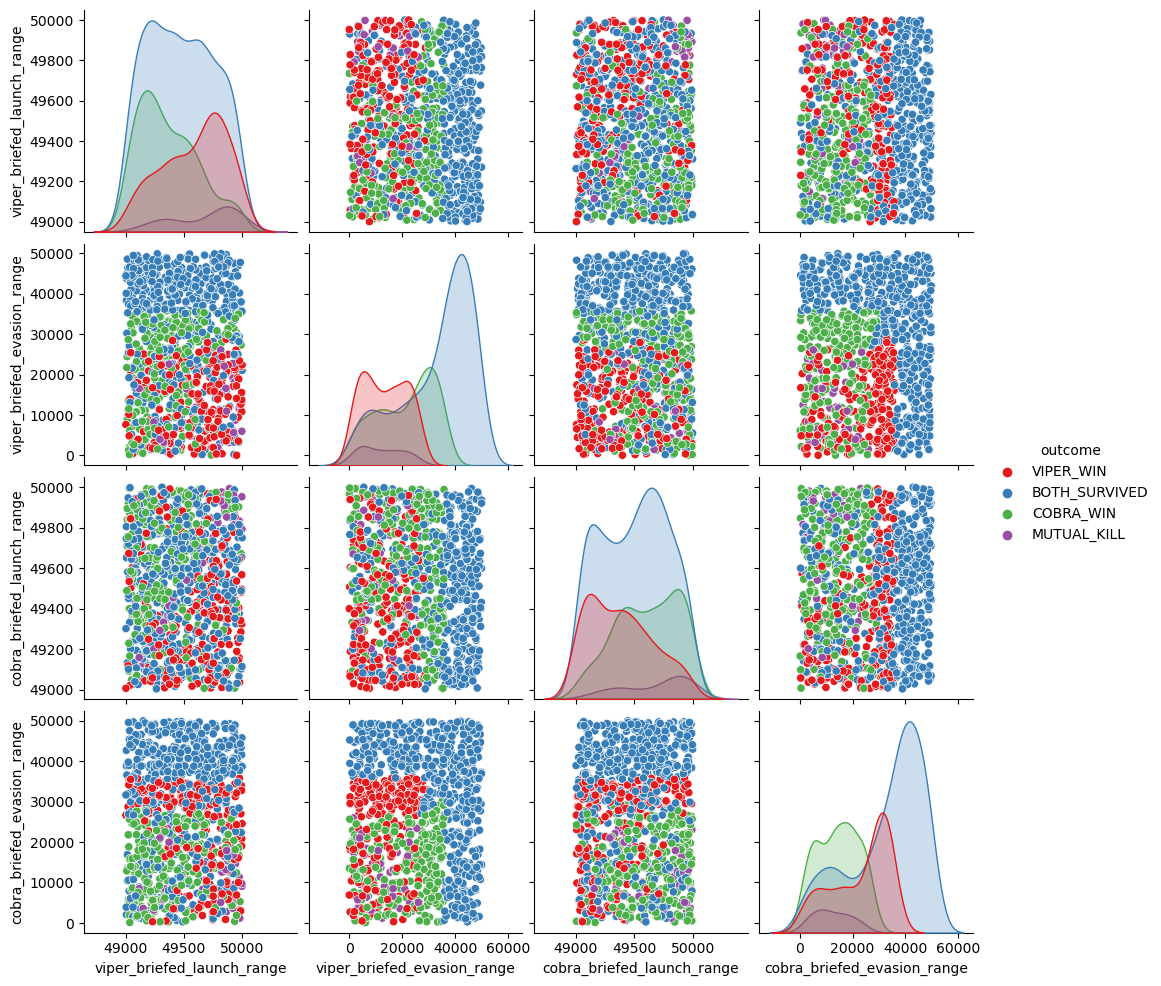

In [18]:
sns.pairplot(df2, hue="outcome", palette="Set1")

C:\Users\mikep\AppData\Local\Temp\ipykernel_44196\2095915165.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.corr(),


<Axes: >

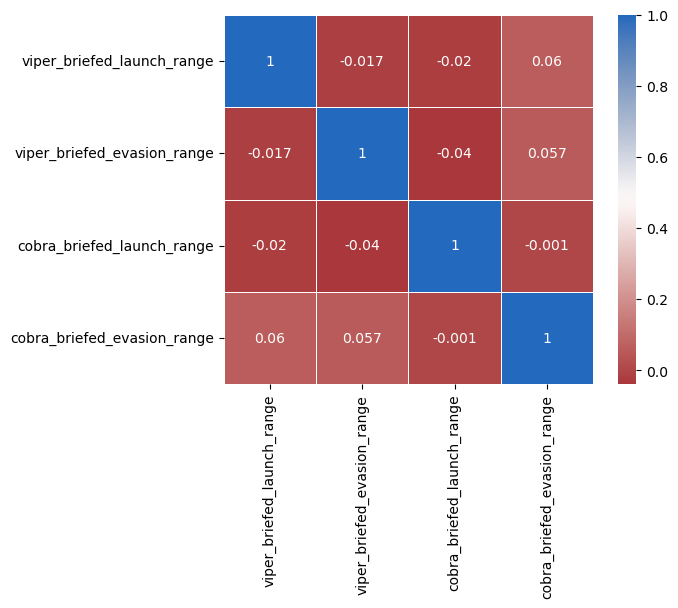

In [19]:
sns.heatmap(
    df2.corr(), 
    annot=True,
    square = True,
    linewidths = .5,
    cmap="vlag_r"
)

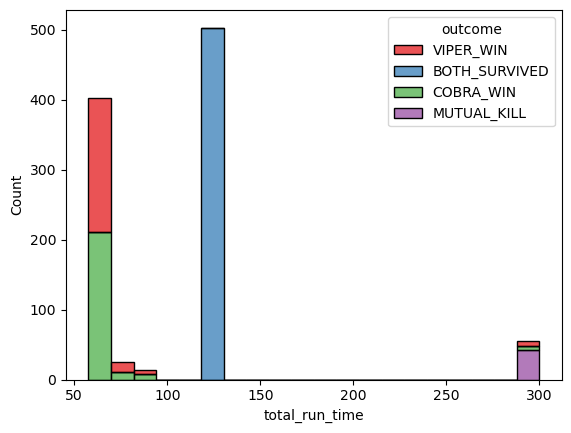

In [48]:
_ = sns.histplot(data=df, x="total_run_time", hue="outcome", multiple="stack", palette="Set1")

# Case 2

In [21]:
df_case2 = run_msl_evasion_study(
    study_name="msl_evasion-case-2",
    random_seed=1234,
    max_runs=1000,
    min_lr = 20_000.0,
    max_lr = 50_000.0,
    min_er = 0_000.0,
    max_er = 50_000.0,
    y_offset=0.0
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Total Run Time =  1 152.0
Total Run Time =  2 67.69999999999999
Total Run Time =  3 58.9
Total Run Time =  4 121.69999999999999
Total Run Time =  5 61.2
Total Run Time =  6 128.29999999999998
Total Run Time =  7 85.1
Total Run Time =  8 141.6
Total Run Time =  9 100.1
Total Run Time =  10 126.19999999999999
Total Run Time =  11 95.5
Total Run Time =  12 69.69999999999999
Total Run Time =  13 142.6
Total Run Time =  14 102.39999999999999
Total Run Time =  15 72.19999999999999
Total Run Time =  16 133.0
Total Run Time =  17 139.1
Total Run Time =  18 99.6
Total Run Time =  19 101.19999999999999
Total Run Time =  20 133.4
Total Run Time =  21 143.79999999999998
Total Run Time =  22 80.89999999999999
Total Run Time =  23 60.4
Total Run Time =  24 130.6
Total Run Time =  25 98.0
Total Run Time =  26 136.5
Total Run Time =  27 95.0
Total Run Time =  28 90.69999999999999
Total Run Time =  29 164.5
Total Run Time =  30 153.7
Total Run Time =  31 59.9
Total Run Time =  32 60.300000000000004
Tot

In [22]:
df_case2.outcome.value_counts()

BOTH_SURVIVED    529
VIPER_WIN        251
COBRA_WIN        219
MUTUAL_KILL        1
Name: outcome, dtype: int64

In [23]:
df3 = df_case2[[
    "viper_briefed_launch_range", 
    "viper_briefed_evasion_range", 
    "cobra_briefed_launch_range", 
    "cobra_briefed_evasion_range",
    #"viper_launch_range",
    #"cobra_launch_range",
    "outcome"
]]

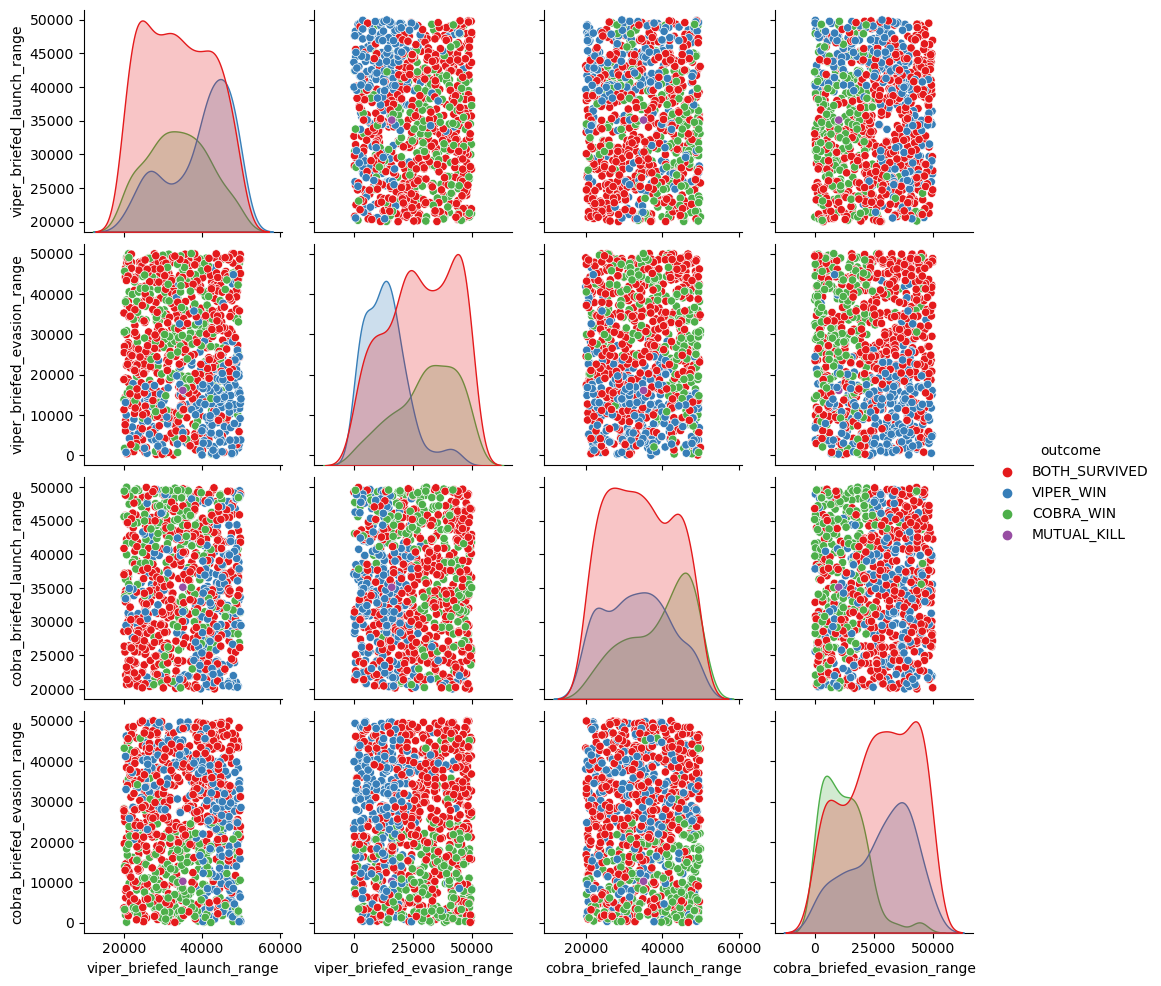

In [24]:
sns.pairplot(df3, hue="outcome", palette="Set1")

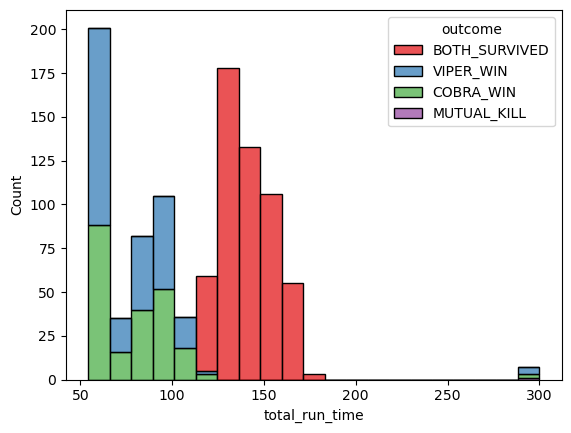

In [49]:
_ = sns.histplot(data=df_case2, x="total_run_time", hue="outcome", multiple="stack", palette="Set1")